In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nannyml as nml
from scipy.spatial.transform import Rotation

# 10 reference periods
# 10 analysis periods
# Days/week * Hours/day * events/hour
DPP = 7*24*12

np.random.seed(23)
s1 = np.random.randn(DPP*20)
x1 = s1 + np.random.randn(DPP*20)/8
x2 = s1 + np.random.randn(DPP*20)/8
x3 = np.random.randn(DPP*20)/8
xdat = np.array([x1, x2, x3]).T

rot = Rotation.from_euler('z', 90, degrees=True)

# following matrix multiplication implementation, we need a 3xN data matrix hence we transpose
ydat = np.matmul(rot.as_matrix(), xdat.T).T

# create overall array that has drifted and not drifted subsets.
# drift is sudden and affects last 5 weeks
dataar = np.concatenate(
    (xdat[:-5*DPP], ydat[-5*DPP:]),
    axis=0
)

# convert data to dataframe
datadf = pd.DataFrame(dataar, columns=['feature1', 'feature2', 'feature3'])

# add "timestamp" column
datadf = datadf.assign(ordered = pd.date_range(start='1/6/2020', freq='5min', periods=20*DPP))

# Adding helper column - duplicates date range functionality
datadf['week'] = datadf.ordered.dt.isocalendar().week - 1
# Adding partition column
datadf['partition'] = 'reference'
datadf.loc[datadf.week >= 11, ['partition']] = 'analysis'

# Assign random predictions and targets (we won't be using them but they are needed for NannyML)
datadf = datadf.assign(y_pred_proba = np.random.rand(DPP*20))
datadf = datadf.assign(y_true = np.random.randint(2, size=DPP*20))

Text(0.5, 0.98, 'Data Distributions before and after rotation drift')

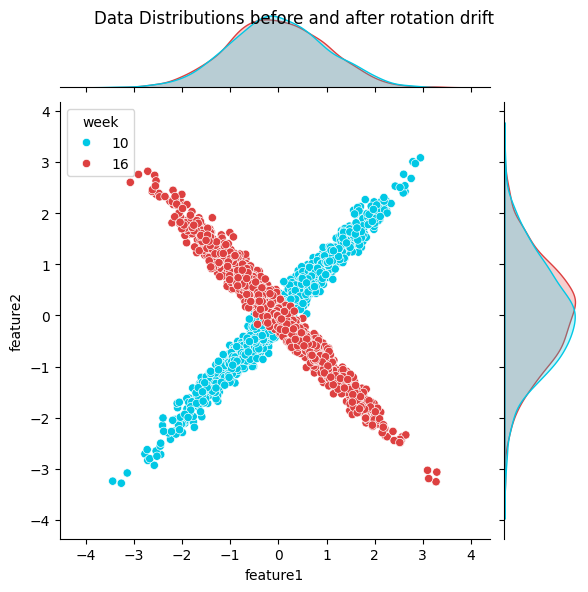

In [ ]:
# let's construct a dataframe for visuzlization purposes
dat1 = datadf.loc[datadf.week == 10, ['feature1', 'feature2']][:1500]
dat1['week'] = 10
dat2 = datadf.loc[datadf.week == 16, ['feature1', 'feature2']][:1500]
dat2['week'] = 16
data_sample = pd.concat([dat1, dat2], ignore_index=True)

# let's plot
colors = nml.plots.colors.Colors
figure = sns.jointplot(
    data=data_sample,
    x="feature1",
    y="feature2",
    hue="week",
    palette=[colors.BLUE_SKY_CRAYOLA.value, colors.RED_IMPERIAL.value]
)
figure.fig.suptitle('Data Distributions before and after rotation drift')

In [ ]:
figure.savefig("../_static/how-it-works/butterfly-scatterplot.svg")

In [ ]:
# Let's first create the analysis and reference datasets NannyML needs.
reference_df = datadf.loc[datadf['partition'] == 'reference'].reset_index(drop=True)
reference_df.drop(['week', 'partition'], axis=1, inplace=True)
analysis_df = datadf.loc[datadf['partition'] == 'analysis'].reset_index(drop=True)
analysis_df.drop(['y_true', 'week', 'partition'], axis=1, inplace=True)

feature_column_names = ['feature1', 'feature2', 'feature3']

# Let's instantiate and calibrate univariate drift
univariate_calculator = nml.UnivariateDriftCalculator(
    column_names=feature_column_names,
    timestamp_column_name='ordered',
    continuous_methods=['kolmogorov_smirnov'],
    categorical_methods=['chi2'],
    chunk_size=DPP
)
univariate_calculator.fit(reference_data=reference_df)

# let's compute (and visualize) results across all the dataset.
univariate_results = univariate_calculator.calculate(data=analysis_df)
figure = univariate_results.filter(
    period='all',
    column_names=univariate_results.continuous_column_names
).plot(kind='distribution')
figure.show()

In [ ]:
figure.write_image('../_static/how-it-works/butterfly-univariate-drift-distributions.svg')

In [ ]:
# Let's compute multivariate drift
rcerror_calculator = nml.DataReconstructionDriftCalculator(
    column_names=feature_column_names,
    timestamp_column_name='ordered',
    chunk_size=DPP
).fit(reference_data=reference_df)
# let's compute results for analysis period
rcerror_results = rcerror_calculator.calculate(data=analysis_df)

# let's visualize results across all the dataset
figure1 = rcerror_results.plot()
figure1.show()

In [ ]:
figure1.write_image('../_static/how-it-works/butterfly-multivariate-drift-pca.svg')

In [ ]:
# Let's compute multivariate drift
drift_classifier = nml.DomainClassifierCalculator(
    feature_column_names=feature_column_names,
    timestamp_column_name='ordered',
    chunk_size=DPP
).fit(reference_data=reference_df)
# let's compute results for analysis period
drift_classifier_results = drift_classifier.calculate(data=analysis_df)

# let's visualize results across all the dataset
figure2 = drift_classifier_results.plot()
figure2.show()

In [ ]:
figure2.write_image('../_static/how-it-works/butterfly-multivariate-drift-cdd.svg')